### Objective: To apply kNN on amazon fine food reviews using both kd-tree and brute force algo

In [131]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [133]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [134]:
# Loading data 
customer_reviews = pd.read_csv('../input/Reviews.csv')
customer_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [135]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [136]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [137]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [138]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [139]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [140]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [141]:
# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [142]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
{"she's", 'wasn', "weren't", 'below', 'did', 'd', "you'll", "didn't", 'been', 'above', 'up', 'each', 'under', 'now', 'is', "you're", 'didn', 'for', 'no', 'shouldn', 'don', 'as', 'than', 'after', 'being', 'themselves', 'and', 'do', "you've", 've', "won't", 'has', 'wouldn', 'or', 'any', 'hadn', 'while', 'mustn', 'out', 'those', 'few', 'will', 'doesn', 'shan', 'ma', 'too', 'had', 'the', 'our', 're', 'it', 'does', 'their', 'down', "should've", 'during', 'these', 'its', 'yourself', 'but', 'very', 'should', 'about', 'all', 'some', 'in', 'have', 'himself', 'here', 'o', 'your', "needn't", "you'd", 'couldn', 'on', 'she', 'needn', 'what', 'myself', 'which', "isn't", 'him', 'because', 'his', 'by', 'with', 'doing', 'll', 'where', 'until', 'of', 'both', 'against', 'won', "couldn't", 'isn', 'so', 'further', 'at', 'whom', "shouldn't", "it's", 'from', 'there', 'if', 'then', 'me', 'into'

In [143]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


### Feature Engineering

In [144]:
# concatenating summary and text features to
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [145]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
            
        

In [146]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [147]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g...",love book miss hard cover version grew read se...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...,chicken soup rice month fun way children learn...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...,good swingi rhythm read aloud great littl book...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...,great way learn month book poetri month year g...


### Observation:
Dataset is highly imbalanced. Out of 364171 reviews only 57110 reviews are negative and rest are positive. 

 

In [148]:
# sorting whole  data based on time
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)


In [149]:
b.head(20) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like books or movies.

In [150]:
# removing reviews that belong to other products
regex =  re.compile(r'book|entertaining|funny|movie|show|film|series|educational|storyteller|comedic') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )

In [151]:
# Number of reviews left
b.shape

(353205, 12)

In [152]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


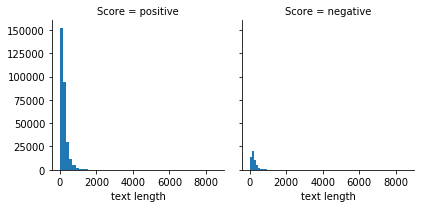

In [153]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)

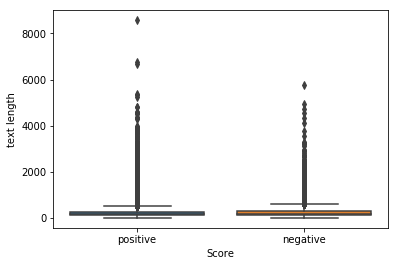

In [154]:
sns.boxplot(x='Score', y='text length', data=b)

 From above plots it is clear that text length is not that good feature for classification

### Function for standardizing data

In [155]:
from sklearn.preprocessing import StandardScaler

In [156]:

def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [157]:
# taking top 60k points for training and testing
sampled_data = b.head(60000)

In [158]:
sampled_data['Score'].value_counts()

positive    53151
negative     6849
Name: Score, dtype: int64

### Function to find optimal K for KNN 

In [159]:
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report


In [160]:
# using brute force algorithm

def find_optimal_k_brute(X_train , Y_train):
    
    neighbors = list( x for x in range(1,20) if x%2!=0)
    tuned_parameters = {'n_neighbors': neighbors}

    clf = KNeighborsClassifier( weights = 'distance' , algorithm = 'brute' , n_jobs = -1 )
    tscv = TimeSeriesSplit(n_splits=3)                    
    knn_clf = RandomizedSearchCV(clf,tuned_parameters , cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
    knn_clf.fit(X_train , Y_train) 
    
    cv_score = list(knn_clf.cv_results_.get('mean_test_score'))
    k_values = neighbors
    for i in range(len(cv_score)):
        print('f1_score for k = ',k_values[i],'is ',cv_score[i] )

    acc_score= knn_clf.cv_results_.get('mean_test_score')
    error = [1-x for x in acc_score]

    hyperparam = neighbors
    plt.plot(hyperparam ,error ,'g' ,label="knn classifier"  )
    plt.xlabel('Hyperparam')
    plt.ylabel('error')
    plt.title('error for each k')
    plt.legend()
    plt.grid()
    plt.show()
    print("best parameter:" ,knn_clf.best_params_ )
    return knn_clf.best_params_['n_neighbors']


In [161]:
# using kd tree 

def find_optimal_k_kd_tree(X_train , Y_train):
    
    
    neighbors = list( x for x in range(1,20) if x%2!=0)
    tuned_parameters = {'n_neighbors': neighbors}

    clf = KNeighborsClassifier( weights = 'distance' , algorithm = 'kd_tree' , n_jobs = -1 )
    tscv = TimeSeriesSplit(n_splits=3)  
    knn_clf = RandomizedSearchCV(clf,tuned_parameters , cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
    knn_clf.fit(X_train , Y_train) 
    
    cv_score = list(knn_clf.cv_results_.get('mean_test_score'))
    k_values = neighbors
    for i in range(len(cv_score)):
        print('f1_score for k = ',k_values[i],'is ',cv_score[i] )

    acc_score= knn_clf.cv_results_.get('mean_test_score')
    error = [1-x for x in acc_score]

    hyperparam = neighbors
    plt.plot(hyperparam ,error ,'g' ,label="knn classifier"  )
    plt.xlabel('Hyperparam')
    plt.ylabel('error')
    plt.title('error for each k')
    plt.legend()
    plt.grid()
    plt.show()
    print("best parameter:" ,knn_clf.best_params_ )
    return knn_clf.best_params_['n_neighbors']




### Function to fit data into model and find accuracy 

In [162]:
def brute_model(X_train , Y_train , X_test , Y_test , k ):
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=k , n_jobs = -1 , weights = 'distance'  , algorithm = 'brute' )

    # fitting the model
    knn_optimal.fit(X_train , Y_train)
    
    print('Test accuracy: ',knn_optimal.score(X_test , Y_test))
    # train accuracy
    #print('Train accuracy: ',knn_optimal.score(X_train , Y_train))

    test_prediction = knn_optimal.predict(X_test)
    print(classification_report(Y_test, test_prediction))

    import scikitplot.metrics as sciplot
    sciplot.plot_confusion_matrix(Y_test, test_prediction)
    plt.show()
    

In [163]:
def kd_tree_model(X_train , Y_train , X_test , Y_test , k ):
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=k , n_jobs = -1 , weights = 'distance'  , algorithm = 'kd_tree' )

    # fitting the model
    knn_optimal.fit(X_train , Y_train)
    
    print('Test accuracy: ',knn_optimal.score(X_test , Y_test))
    # train accuracy
    #print('Train accuracy: ',knn_optimal.score(X_train , Y_train))

    test_prediction = knn_optimal.predict(X_test)
    print(classification_report(Y_test, test_prediction))

    import scikitplot.metrics as sciplot
    sciplot.plot_confusion_matrix(Y_test, test_prediction)
    plt.show()

#### Splittting the data into train and test

In [164]:

# splitting  data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1                               # positive-----> 1
    else:
        return -1                              # negative-----> -1 
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test  = train_test_split(sampled_data['CleanedText'],sampled_data['Score'], test_size=0.3, random_state=45)


## Bag of Words

In [128]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,2) , dtype = 'float' , min_df = 50 , max_features = 2000)

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (42000, 2000)
Test Dataset:  (18000, 2000)


In [129]:
# standarzing both train and test matrix 

bow_std_X_train_matrix = std_data(bow_X_train_matrix)
bow_std_X_test_matrix = std_data(bow_X_test_matrix)

## Brute Force

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


f1_score for k =  1 is  0.9195235186635335
f1_score for k =  3 is  0.9386672336879385
f1_score for k =  5 is  0.9422438797947527
f1_score for k =  7 is  0.9428209671790334
f1_score for k =  9 is  0.9420084243054034
f1_score for k =  11 is  0.9415688001434338
f1_score for k =  13 is  0.9411914805490018
f1_score for k =  15 is  0.9408165600989642
f1_score for k =  17 is  0.9406488920190648
f1_score for k =  19 is  0.9403347741651348


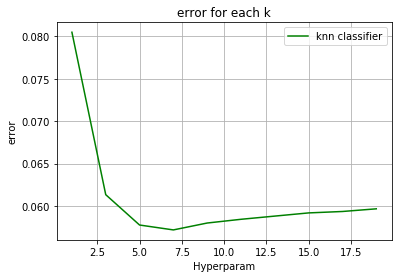

best parameter: {'n_neighbors': 7}


In [130]:
# finding optimal k using find_optimal_k_brute() function
brute_optimal_k = find_optimal_k_brute(bow_std_X_train_matrix , Y_train)

In [96]:
brute_optimal_k

7

Test accuracy:  0.9003888888888889
              precision    recall  f1-score   support

          -1       0.80      0.16      0.27      2042
           1       0.90      0.99      0.95     15958

   micro avg       0.90      0.90      0.90     18000
   macro avg       0.85      0.58      0.61     18000
weighted avg       0.89      0.90      0.87     18000



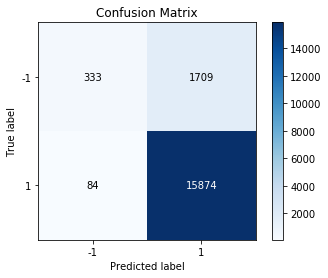

In [95]:
# testing & predicting accuracy of model using brute_optimal_k
brute_model(bow_std_X_train_matrix , Y_train,bow_std_X_test_matrix,Y_test,  brute_optimal_k )

## kd-tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.3min finished


f1_score for k =  1 is  0.9195235186635335
f1_score for k =  3 is  0.9386672336879385
f1_score for k =  5 is  0.9422438797947527
f1_score for k =  7 is  0.9428209671790334
f1_score for k =  9 is  0.9420084243054034
f1_score for k =  11 is  0.9415688001434338
f1_score for k =  13 is  0.9411914805490018
f1_score for k =  15 is  0.9408165600989642
f1_score for k =  17 is  0.9406488920190648
f1_score for k =  19 is  0.9403347741651348


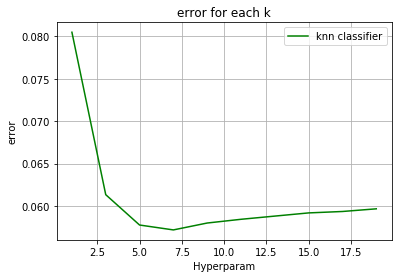

best parameter: {'n_neighbors': 7}


In [98]:
optimal_k = find_optimal_k_kd_tree(bow_std_X_train_matrix , Y_train)

Test accuracy:  0.9003888888888889
              precision    recall  f1-score   support

          -1       0.80      0.16      0.27      2042
           1       0.90      0.99      0.95     15958

   micro avg       0.90      0.90      0.90     18000
   macro avg       0.85      0.58      0.61     18000
weighted avg       0.89      0.90      0.87     18000



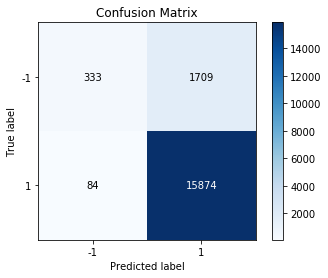

In [99]:
kd_tree_model(bow_std_X_train_matrix , Y_train,bow_std_X_test_matrix,Y_test,  brute_optimal_k )

# TF-IDF

In [100]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 50 , max_features = 2000)
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)


(42000, 2000)
(18000, 2000)


In [102]:
# standardizing train/test data using std_data() function
tfidf_std_X_train_matrix = std_data(tf_idf_X_train_matrix)
tfidf_std_X_test_matrix = std_data(tf_idf_X_test_matrix)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.9min finished


f1_score for k =  1 is  0.9334402901304214
f1_score for k =  3 is  0.9334256581494628
f1_score for k =  5 is  0.9401771420443709
f1_score for k =  7 is  0.9404032877848781
f1_score for k =  9 is  0.9402996089663617
f1_score for k =  11 is  0.940080477502526
f1_score for k =  13 is  0.9398476631610018
f1_score for k =  15 is  0.9396413214840068
f1_score for k =  17 is  0.9395142719331394
f1_score for k =  19 is  0.9394925427496099


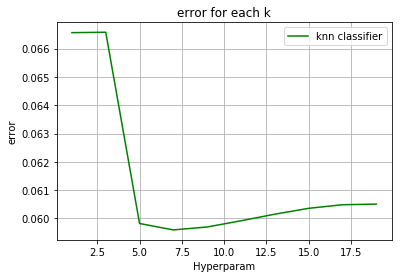

best parameter: {'n_neighbors': 7}


In [103]:
# finding optimal k using find_optimal_k_brute() function
brute_optimal_k = find_optimal_k_brute(tfidf_std_X_train_matrix , Y_train)

Test accuracy:  0.8932777777777777
              precision    recall  f1-score   support

          -1       0.75      0.09      0.16      2042
           1       0.90      1.00      0.94     15958

   micro avg       0.89      0.89      0.89     18000
   macro avg       0.82      0.54      0.55     18000
weighted avg       0.88      0.89      0.85     18000



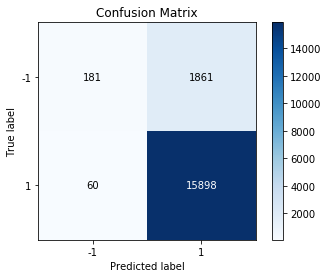

In [104]:
brute_model(tfidf_std_X_train_matrix , Y_train,tfidf_std_X_test_matrix,Y_test,  brute_optimal_k )

## kd tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.7min finished


f1_score for k =  1 is  0.9334402901304214
f1_score for k =  3 is  0.9334256581494628
f1_score for k =  5 is  0.9401771420443709
f1_score for k =  7 is  0.9404032877848781
f1_score for k =  9 is  0.9402996089663617
f1_score for k =  11 is  0.940080477502526
f1_score for k =  13 is  0.9398476631610018
f1_score for k =  15 is  0.9396413214840068
f1_score for k =  17 is  0.9395142719331394
f1_score for k =  19 is  0.9394925427496099


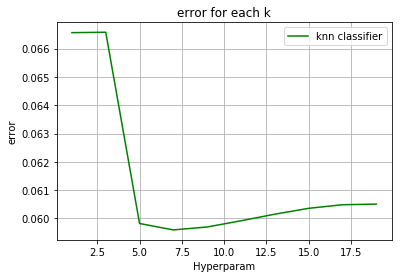

best parameter: {'n_neighbors': 7}


In [105]:
optimal_k = find_optimal_k_kd_tree(tfidf_std_X_train_matrix , Y_train)

Test accuracy:  0.8932777777777777
              precision    recall  f1-score   support

          -1       0.75      0.09      0.16      2042
           1       0.90      1.00      0.94     15958

   micro avg       0.89      0.89      0.89     18000
   macro avg       0.82      0.54      0.55     18000
weighted avg       0.88      0.89      0.85     18000



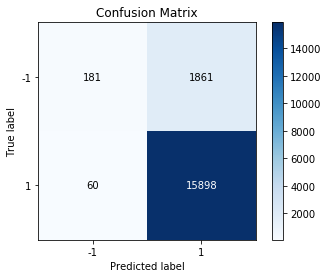

In [106]:
kd_tree_model(tfidf_std_X_train_matrix , Y_train,tfidf_std_X_test_matrix,Y_test,  brute_optimal_k )

# avg word2vec

In [107]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)


In [108]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)


In [109]:
# standrizing data
w2vec_std_X_train_matrix = std_data(w2vec_X_train_matrix)
w2vec_std_X_test_matrix = std_data(w2vec_X_test_matrix)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


f1_score for k =  1 is  0.9284267035765651
f1_score for k =  3 is  0.942455049662511
f1_score for k =  5 is  0.9452027683360246
f1_score for k =  7 is  0.9466942710202739
f1_score for k =  9 is  0.9465016442776306
f1_score for k =  11 is  0.9469454533091985
f1_score for k =  13 is  0.9464760151797094
f1_score for k =  15 is  0.9465478768246419
f1_score for k =  17 is  0.9466694570840123
f1_score for k =  19 is  0.9463801568792295


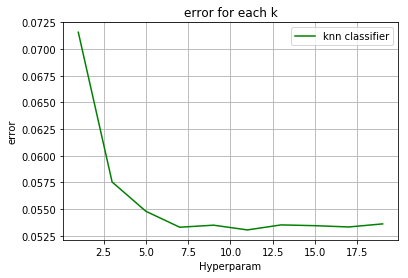

best parameter: {'n_neighbors': 11}


In [110]:
brute_optimal_k = find_optimal_k_brute(w2vec_std_X_train_matrix , Y_train)

Test accuracy:  0.9066111111111111
              precision    recall  f1-score   support

          -1       0.74      0.27      0.40      2042
           1       0.91      0.99      0.95     15958

   micro avg       0.91      0.91      0.91     18000
   macro avg       0.83      0.63      0.67     18000
weighted avg       0.89      0.91      0.89     18000



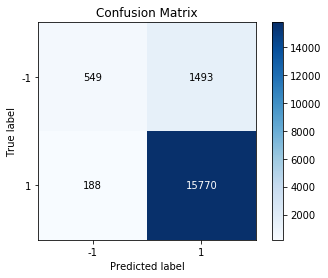

In [112]:
brute_model(w2vec_std_X_train_matrix , Y_train,w2vec_std_X_test_matrix,Y_test,  brute_optimal_k )

## kd tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.7min finished


f1_score for k =  1 is  0.9284267035765651
f1_score for k =  3 is  0.942455049662511
f1_score for k =  5 is  0.9452027683360246
f1_score for k =  7 is  0.9466942710202739
f1_score for k =  9 is  0.9465016442776306
f1_score for k =  11 is  0.9469454533091985
f1_score for k =  13 is  0.9464760151797094
f1_score for k =  15 is  0.9465478768246419
f1_score for k =  17 is  0.9466694570840123
f1_score for k =  19 is  0.9463801568792295


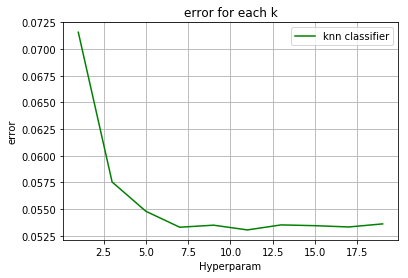

best parameter: {'n_neighbors': 11}


In [115]:
optimal_k = find_optimal_k_kd_tree(w2vec_std_X_train_matrix , Y_train)

Test accuracy:  0.9066111111111111
              precision    recall  f1-score   support

          -1       0.74      0.27      0.40      2042
           1       0.91      0.99      0.95     15958

   micro avg       0.91      0.91      0.91     18000
   macro avg       0.83      0.63      0.67     18000
weighted avg       0.89      0.91      0.89     18000



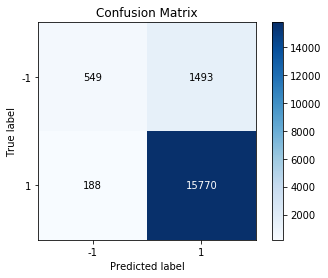

In [116]:
kd_tree_model(w2vec_std_X_train_matrix , Y_train,w2vec_std_X_test_matrix,Y_test,  optimal_k )

# tf-idf word2vec

In [120]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [122]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1

    

In [123]:

tfidf_w2vec_std_X_train_matrix = std_data(tfidf_sent_vectors_X_train)
tfidf_w2vec_std_X_test_matrix = std_data(tfidf_sent_vectors_X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


f1_score for k =  1 is  0.9214079117760613
f1_score for k =  3 is  0.9372310541144433
f1_score for k =  5 is  0.9417321335425249
f1_score for k =  7 is  0.9435178659750239
f1_score for k =  9 is  0.9439495002300121
f1_score for k =  11 is  0.9442772987149024
f1_score for k =  13 is  0.9446351520823104
f1_score for k =  15 is  0.9444183434370736
f1_score for k =  17 is  0.9443553221137684
f1_score for k =  19 is  0.9444967591492006


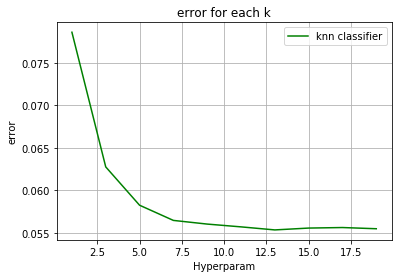

best parameter: {'n_neighbors': 13}


In [124]:

brute_optimal_k = find_optimal_k_brute(tfidf_w2vec_std_X_train_matrix,Y_train )


Test accuracy:  0.9021111111111111
              precision    recall  f1-score   support

          -1       0.72      0.22      0.34      2042
           1       0.91      0.99      0.95     15958

   micro avg       0.90      0.90      0.90     18000
   macro avg       0.82      0.61      0.64     18000
weighted avg       0.89      0.90      0.88     18000



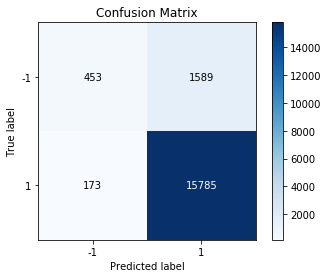

In [125]:
brute_model(tfidf_w2vec_std_X_train_matrix , Y_train,tfidf_w2vec_std_X_test_matrix,Y_test,  brute_optimal_k )

## kd-tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.5min finished


f1_score for k =  1 is  0.9214079117760613
f1_score for k =  3 is  0.9372310541144433
f1_score for k =  5 is  0.9417321335425249
f1_score for k =  7 is  0.9435178659750239
f1_score for k =  9 is  0.9439495002300121
f1_score for k =  11 is  0.9442772987149024
f1_score for k =  13 is  0.9446351520823104
f1_score for k =  15 is  0.9444183434370736
f1_score for k =  17 is  0.9443553221137684
f1_score for k =  19 is  0.9444967591492006


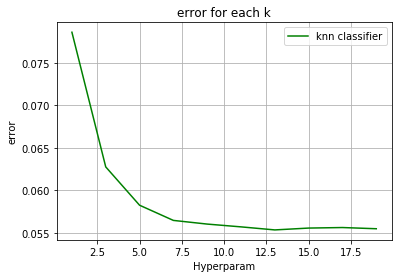

best parameter: {'n_neighbors': 13}


In [126]:
optimal_k = find_optimal_k_kd_tree(tfidf_w2vec_std_X_train_matrix , Y_train)

Test accuracy:  0.9021111111111111
              precision    recall  f1-score   support

          -1       0.72      0.22      0.34      2042
           1       0.91      0.99      0.95     15958

   micro avg       0.90      0.90      0.90     18000
   macro avg       0.82      0.61      0.64     18000
weighted avg       0.89      0.90      0.88     18000



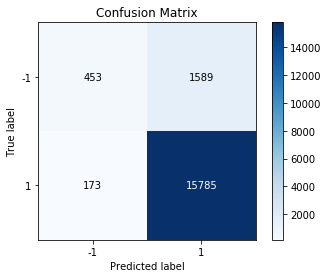

In [127]:
kd_tree_model(tfidf_w2vec_std_X_train_matrix , Y_train,tfidf_w2vec_std_X_test_matrix,Y_test,  optimal_k )

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

In [2]:
x.field_names = ["Model", "Hyperparameter k", "precision", "recall" , "f1-score"]
x.add_row(['knn using bow & brute' , '7' , '0.89' , '0.90' , '0.87'])
x.add_row(['knn using bow & kd_tree' , '7' , '0.89' , '0.90' , '0.87'])
x.add_row(['knn using tfidf & brute' , '7' , '0.88' , '0.89' , '0.85'])
x.add_row(['knn using tfidf & kd_tree' , '7' , '0.88' , '0.89' , '0.85'])
x.add_row(['knn using w2vec & brute' , '11' , '0.89' , '0.91' , '0.89'])
x.add_row(['knn using w2vec & kd_tree' , '11' , '0.89' , '0.91' , '0.89'])
x.add_row(['knn using tfidf-w2vec & brute' , '13' , '0.89' , '0.90' , '0.88'])
x.add_row(['knn using tfidf-w2vec & kd_tree' , '13' , '0.89' , '0.90' , '0.88'])
print(x)

+---------------------------------+------------------+-----------+--------+----------+
|              Model              | Hyperparameter k | precision | recall | f1-score |
+---------------------------------+------------------+-----------+--------+----------+
|      knn using bow & brute      |        7         |    0.89   |  0.90  |   0.87   |
|     knn using bow & kd_tree     |        7         |    0.89   |  0.90  |   0.87   |
|     knn using tfidf & brute     |        7         |    0.88   |  0.89  |   0.85   |
|    knn using tfidf & kd_tree    |        7         |    0.88   |  0.89  |   0.85   |
|     knn using w2vec & brute     |        11        |    0.89   |  0.91  |   0.89   |
|    knn using w2vec & kd_tree    |        11        |    0.89   |  0.91  |   0.89   |
|  knn using tfidf-w2vec & brute  |        13        |    0.89   |  0.90  |   0.88   |
| knn using tfidf-w2vec & kd_tree |        13        |    0.89   |  0.90  |   0.88   |
+---------------------------------+--------

### Observation
1. Among all four text to vector conversion technique avg w2vec is giving compartively better classification results using kNN.  
2. BOW and Tf-Idf generates vector of very high dimensions hence it is not good to apply knn using kd-tree algo since kd-tree doesn't work well in high dimensions
3. kNN is a quite slow algorithm even after taking a very small sample out of whole dataset there is huge delay in getting output.
4. Performance of both algo brute force and kd-tree is almost similar.
5. Train and test time for both brute force and kd tree is also almost same.



 

### Conclusion
1. kNN performs poorly in case of both high dimensions and unbalanced data.
2. Since kNN doesn't work well in high dimensions hence it is not good for classifying text data.
 

In [ ]:
import sys
sys.path.append('C:\\Users\\tushar\\AppData\\Local\\MiKTeX\\2.9\\pdftex\\config')